1. Initial capital: 1000W
2. Select the top 100 stocks in each time cross-section
3. Trade according to the closing price of the last trading day at the end of the month

In [1]:
##每天的股票不同
def update_dic():
    global today
    global trade_dic
    global h_dic
    slist = list(h_dic.keys())
    temp = pd.DataFrame(trade_dic['pctChg'].loc[today,slist])
    temp.columns = ['pctChg']
    temp = temp.fillna(0)
    temp['pctChg'] = temp['pctChg']/100 + 1
    temp = temp.reset_index(['code'])
    pct = {x:y for (x,y) in zip(temp['code'],temp['pctChg'])}
    for key in pct.keys():
        h_dic[key] = h_dic[key]*pct[key]
    return

def order_sell(security,target=0):
    
    global trade_dic
    global today
    global h_dic
    global ordercost
    global costlist
    global cash
    global log
    close = trade_dic['close'].loc[today,security]
    value = h_dic[security] - target*h_dic[security]  #要卖出的金额
    #实际获取的金额
    real_v = value * (1-ordercost['close_tax']) - max(value*ordercost['close_commission'],ordercost['min_commission'])
    cash = cash + real_v  #更新现金
    costlist.append(value - real_v)  #成本
    if target==0:
        del h_dic[security]  #删除持仓
    else:
        h_dic[security] = h_dic[security] - value
    log.append([today,'卖出',security,real_v,close])
    return

def order_buy(security,value):
    global trade_dic
    global today
    global h_dic
    global ordercost
    global costlist
    global cash
    global log
    #计算实际使用金额
    close = trade_dic['close'].loc[today,security]
    use_value = int(value / (close*100)) * (close*100)    #买的时候只能整手整手的购买
    #扣除成本
    real_v = use_value * (1-ordercost['open_tax']) - max(use_value*ordercost['open_commission'],ordercost['min_commission']) 
    try:
        h_dic[security] = h_dic[security] + real_v
    except:
        h_dic[security] = real_v  
    costlist.append(use_value - real_v)  #交易成本
    cash = cash - use_value   #更新现金
    log.append([today,'买入',security,use_value,close])
    return
##当天持仓的股票和总资产都汇总一下
def summary_today():
    global h_dic
    global cash
    global codelist
    global holdlist
    global caplist
    codelist.append(list(h_dic.keys()))
    hold = sum(list(h_dic.values()))
    holdlist.append(hold)
    caplist.append(hold+cash)
    return

In [175]:
##回测结果已出，评估回测结果：
def metric_fun(caplist,daterange,rf,benchmark=[]):
    '''
    caplist:净值列表，可能为资产额
    daterange:回测区间，列表
    rf：年化无风险利率
    benchmark:dataframe格式，必须有列名为pctChg,代表日收益，且：3%表示为0.03的小数格式。
    benchmark默认为[]，此时结果不输出与benchmark计算有关的指标
    '''
    c0 = caplist[0]
    rdf = pd.DataFrame(index=daterange)
    rdf['pf_return'] = caplist
    rdf['pf_return'] = rdf['pf_return'] / c0
    rdf['pf_pct'] = rdf['pf_return'].pct_change()
    rdf['pf_max'] = rdf['pf_return'].cummax()

    total_r = (list(rdf['pf_return'])[-1] - 1)*100  #回测收益
    year_r = total_r / len(rdf) * 250  #年化收益
    
    rf_ = (rf+1)**(1/250) - 1
    sharpe = (250**(1/2))*(rdf['pf_pct'].mean()-rf_)/rdf['pf_pct'].std() #夏普比率(年化)
    rdf['drawdown'] = rdf['pf_return'] / rdf['pf_max'] - 1
    maxdrawdown = abs(rdf['drawdown'].min()*100)  #最大回撤
    sortino = (250**(1/2))*(rdf['pf_pct'].mean()-rf_)/rdf.query('pf_pct<0')['pf_pct'].std()  #索提诺率(年化)
    
    times_win = list(rdf['pf_pct']>0).count(True) #盈利次数
    times_loss = len(rdf) - times_win  #亏损次数
    vic = times_win / len(rdf)  #日胜率

    calmar = year_r / maxdrawdown  #卡尔玛比率
    vol_pf = rdf['pf_pct'].std()  #策略波动率
    rdf['pos'] = range(len(rdf))
    n = list(rdf['drawdown']).index(rdf['drawdown'].min())
    n0 = list(rdf.query('drawdown==0')['pos'])
    ndiff = [x-n for x in n0]
    def find_pos(t):
        import numpy as np
        #查找列表中小于0的最大值所在的索引
        t = np.array(t)
        si = np.argwhere(t<=0)
        result_index = si[t[si].argmax()][0]
        return result_index
    nr = find_pos(ndiff)
    begin_drawdown = rdf.index[n0[nr]]  #最大回撤开始时间
    end_drawdown = rdf.index[n] #最大回撤结束时间
    
    value0 = ['回测收益','%.3f'%total_r+'%','年化收益','%.3f'%year_r+'%',
              '年化夏普','%.5f'%sharpe,'年化索提诺','%.5f'%sortino,
              '最大回撤','%.3f'%maxdrawdown+'%','卡尔玛率','%.5f'%calmar,
              '最大回撤开始时间',begin_drawdown,'最大回撤结束时间',end_drawdown,
              '策略波动率','%.5f'%vol_pf,'日胜率','%.5f'%vic,
              '盈利天数',int(times_win),'亏损天数',int(times_loss)]
    
    value0 = pd.DataFrame(np.array(value0).reshape(-1,4))
    value0.columns = ['']*4
    value0.index = ['']*6
    
    if len(benchmark) != 0:
        rdf['bm_pct'] = list(benchmark['pctChg'])
        rdf['bm_return'] = (rdf['bm_pct'] + 1).cumprod()
        extra_r = (list(rdf['pf_return'])[-1] - list(rdf['bm_return'])[-1])*100  #超额收益
        bm_r = (list(rdf['bm_return'])[-1] - 1)*100  #基准收益
        from sklearn import linear_model
        lr = linear_model.LinearRegression()
        
        ldf = rdf[['pf_pct','bm_pct']]
        ldf = ldf.dropna()
        y = ldf['pf_pct'].values.reshape(-1,1)
        x = ldf['bm_pct'].values.reshape(-1,1)
        lr.fit(x,y) 
        alpha_ = lr.intercept_[0]  #alpha
        beta_ = lr.coef_[0][0]  #beta

        extra_day = (rdf['pf_pct'] - rdf['bm_pct']).mean()*100  #日均超额收益
        rdf['extra'] = (rdf['pf_return'] - rdf['bm_return'])
        rdf['drawdown_extra'] = rdf['extra'].cummax()   
        extra_drawdown = abs(rdf['drawdown_extra'].min()*100)  #超额收益最大回撤

        extra_return = y - x
        red_error = lr.predict(x) - y
        re_std = red_error.std()
        information_ratio = extra_return.mean() / re_std
        information_ratio = information_ratio*(250**(1/2))  #信息比率(年化)

        vol_bm = ldf['bm_pct'].std()  #基准波动率
        
        value1 = ['基准收益','%.3f'%bm_r+'%','超额收益','%.3f'%extra_r+'%',
                  '基准波动率','%.5f'%vol_bm,'超额最大回撤','%.3f'%extra_drawdown+'%',
                  '日均超额收益','%.3f'%extra_day+'%','信息比率(年化)','%.5f'%information_ratio,
                  'alpha','%.5f'%alpha_,'beta','%.5f'%beta_]
        
        value1 = pd.DataFrame(np.array(value1).reshape(-1,4))
        value1.columns = ['']*4
        value1.index = ['']*4
    else:
        value1 = []
    
    if len(value1) != 0:
        mdf = pd.concat([value0,value1])
    else:
        mdf = value0
    
    return mdf,rdf

##画图
def plot(rdf,xsize):
    x = rdf.index
    b = x[0]
    e = x[-1]
    x = [datetime.strptime(i,'%Y%m%d') for i in x]
    fig = plt.figure(figsize=(xsize,xsize/2))
    '''
    净值曲线
    '''
    ax1 = plt.subplot(3,1,1)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    y1 = rdf['pf_return'] - 1
    
    if 'bm_return' in rdf.columns:
        y2 = rdf['bm_return'] - 1
        l2,= plt.plot(x,y2,'#8B0000',alpha=0.7)
    else:
        pass

    plt.fill_between(x,0,y1,facecolor='#1E90FF', alpha=0.1)  #绘制面积图
    l1,= plt.plot(x,y1,color='#483D8B',alpha=0.9)
    plt.plot(x,[0]*len(rdf),'k-',alpha=1)
    
    if 'bm_return' in rdf.columns:
        plt.legend([l1,l2],['PortFolio','BenchMark'],fontsize=xsize/1.2,loc='upper left')
    else:
        plt.legend([l1],['PortFolio'],fontsize=xsize/1.2,loc='upper left')
    
    plt.yticks(fontsize=xsize/1.5)
    plt.ylabel('Return',fontsize=xsize)

    plt.xlim(x[0],x[-1])
    plt.grid(True)

    '''
    回撤曲线
    '''
    ax2 = plt.subplot(3,1,2,sharex=ax1)
    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.subplots_adjust(wspace=0,hspace=0)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    y3 = rdf['drawdown']
    plt.fill_between(x,0,y3,facecolor='blue', alpha=0.5)
    plt.plot(x,[0]*len(rdf),'k-',alpha=1)
    plt.yticks(fontsize=xsize/1.5)
    plt.ylabel('Drawdown',fontsize=xsize)
    plt.grid(True)

    '''
    波动
    '''
    ax3 = plt.subplot(3,1,3,sharex=ax1)
    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.subplots_adjust(wspace=0,hspace=0)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    t = rdf.query('pf_pct>0')['pf_pct']
    f = rdf.query('pf_pct<=0')['pf_pct']
    x11 = t.index
    x11 = [datetime.strptime(i,'%Y%m%d') for i in x11]
    y11 = t.values
    x22 = f.index
    x22 = [datetime.strptime(i,'%Y%m%d') for i in x22]
    y22 = f.values

    plt.bar(x=x11,height=y11,width=xsize/75,color='red')
    plt.bar(x=x22,height=y22,width=xsize/75,color='green')
    plt.plot(x,[0]*len(rdf),'k-',alpha=1)
    plt.ylabel('PctChg',fontsize=xsize)
    plt.yticks(fontsize=xsize/1.5)
    plt.xticks(fontsize=xsize)
    plt.grid(True)
    return fig

###画图
def rolling_plot(rdf,rf,rolling_num,xsize):
    rolling_result = []
    for rl_df in rdf.rolling(rolling_num):
        rl_pf_r = list((rl_df['pf_pct'] + 1).cumprod())[-1]   #区间滚动净值

        rf_ = (rf+1)**(1/250) - 1
        rl_sharpe = (250**(1/2))*(rl_df['pf_pct'].mean()- rf_)/ rl_df['pf_pct'].std()  #滚动夏普率
        if 'bm_pct' in rdf.columns:
            rl_bm_r = list((rl_df['bm_pct'] + 1).cumprod())[-1]   #区间BM滚动净值
        else:
            rl_bm_r = 0
        rolling_result.append([rl_pf_r,rl_sharpe,rl_bm_r])
    rolling_rdf = pd.DataFrame(index=daterange,data=rolling_result,columns=['pf_return','sharpe','bm_return'])
    rolling_rdf = rolling_rdf[rolling_num:]

    x = rolling_rdf.index
    b = x[0]
    e = x[-1]
    x = [datetime.strptime(i,'%Y%m%d') for i in x]
    fig = plt.figure(figsize=(xsize,xsize/2))
    '''
    滚动净值曲线
    '''
    ax1 = plt.subplot(3,1,1)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    y1 = rolling_rdf['pf_return'] - 1

    if 'bm_return' in rdf.columns:
        y2 = rolling_rdf['bm_return'] - 1
        l2,= plt.plot(x,y2,'#8B0000',alpha=0.7)
    else:
        pass

    plt.fill_between(x,0,y1,facecolor='#1E90FF', alpha=0.1)  #绘制面积图
    l1,= plt.plot(x,y1,color='#483D8B',alpha=0.9)
    plt.plot(x,[0]*len(rolling_rdf),'k-',alpha=1)

    if 'bm_return' in rdf.columns:
        plt.legend([l1,l2],['PortFolio','BenchMark'],fontsize=xsize/1.2,loc='upper left')
    else:
        plt.legend([l1],['PortFolio'],fontsize=xsize/1.2,loc='upper left')

    plt.yticks(fontsize=xsize/1.5)
    plt.ylabel('Rolling Return',fontsize=xsize)

    plt.xlim(x[0],x[-1])
    plt.grid(True)

    '''
    滚动夏普曲线
    '''
    ax2 = plt.subplot(3,1,2,sharex=ax1)
    plt.setp(ax1.get_xticklabels(),visible=False)
    plt.subplots_adjust(wspace=0,hspace=0)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    y3 = rolling_rdf['sharpe']
    plt.fill_between(x,0,y3,facecolor='blue', alpha=0.5)
    plt.plot(x,[0]*len(rolling_rdf),'k-',alpha=1)
    plt.yticks(fontsize=xsize/1.5)
    plt.ylabel('Rolling Drawdown',fontsize=xsize)
    plt.xticks(fontsize=xsize)
    plt.grid(True)
    return

In [72]:
file = '/Users/cr/Downloads/undergraduate time/大四上/FIN 4998/paper/code/机器学习/'
import pickle
import gc
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [79]:
trade_dic = pickle.load(open(file+'trade_dic','rb'))  #交易bar数据
sec = pickle.load(open(file+'sec','rb'))  #股票排序
month_day = pickle.load(open(file+'month_day','rb'))  #月末调仓日期
daterange = list(trade_dic['close'].index)  #回测日期
day1 = daterange[0]
day2 = daterange[-1]

#获取benchmark
import baostock as bs
lg = bs.login()
rs = bs.query_history_k_data_plus("sh.000300",
    "date,code,open,high,low,close,preclose,volume,amount,pctChg",
    start_date='-'.join([day1[:4],day1[4:6],day1[6:]]), 
    end_date='-'.join([day2[:4],day2[4:6],day2[6:]]), frequency="d")
lg = bs.logout()

login success!
logout success!


In [186]:
##只在月末月初进行调仓
###去除ST，停盘股
#买入100选股数量


#回测初始设定：初始金额1000w
ordercost = {'open_tax':0,               #买入印花税
             'close_tax':0.001,         #卖出印花税
             'open_commission':0.0001,   #买入佣金
             'close_commission':0.0002,   #卖出佣金
             'today_commission':0,       #持有成本：比如杠杆和做空  但是我的策略暂时不考虑这个。
             'min_commission':5}         #最小佣金

cash = 10000000
h_dic = {}
costlist = []  #记录交易成本
holdlist = []  #记录持仓
caplist = []  #记录总资产
codelist = []  #收盘持仓股票
log = []  #记录日志

#回测相关参数
params = {'num':100,#选股数量
         }
    
for today in tqdm(daterange):
    if len(h_dic.keys())>0:
        update_dic()
    else:
        pass

    if today in month_day:

        for i in list(h_dic.keys()):
            order_sell(i)  #卖出之前持仓

        value = cash / num
        #去除ST，停盘股
        sort_ = sec[today]

        st = trade_dic['isST'].loc[today,:]
        st = list(st[st == 1].index)

        nt = trade_dic['close'].loc[today,:]
        nt = nt.apply(lambda x:str(x))
        nt = list(nt[nt=='nan'].index)

        for i in st:
            try:
                sort_.remove(i)
            except:
                pass
        for i in nt:
            try:
                sort_.remove(i)
            except:
                pass

        for i in sort_[:params['num']]:  #买入前num个股票
            order_buy(i,value)
    else:
        pass

    summary_today()

100%|██████████| 2431/2431 [00:13<00:00, 181.10it/s]


In [187]:
log_df = pd.DataFrame(log,columns=['date','order','security','amount','price'])
log_df.to_excel(file+'log.xlsx')

In [ ]:
benchmark = rs.get_data()
benchmark['pctChg'] = benchmark['pctChg'].apply(lambda x:float(x)/100)
rf = 0.02  #年化无风险利率取 2% (影响夏普率与索提诺率的计算结果)

# 全时间段回测结果
    20110930～20210930

In [ ]:
####相对于第一天的收益率
##回测收益：425.298%
##三个图：
##收益图：红线是基准（benchmark）-沪深300
##回撤图
##日收益率波动图

,,,,
,回测收益,425.298%,年化收益,43.737%
,年化夏普,0.66364,年化索提诺,0.82068
,最大回撤,49.343%,卡尔玛率,0.88638
,最大回撤开始时间,20151222,最大回撤结束时间,20181018
,策略波动率,0.01848,日胜率,0.56109
,盈利天数,1364,亏损天数,1067
,基准收益,88.026%,超额收益,337.273%
,基准波动率,0.01442,超额最大回撤,0.264%
,日均超额收益,0.049%,信息比率(年化),0.61943
,alpha,0.00051,beta,0.94442


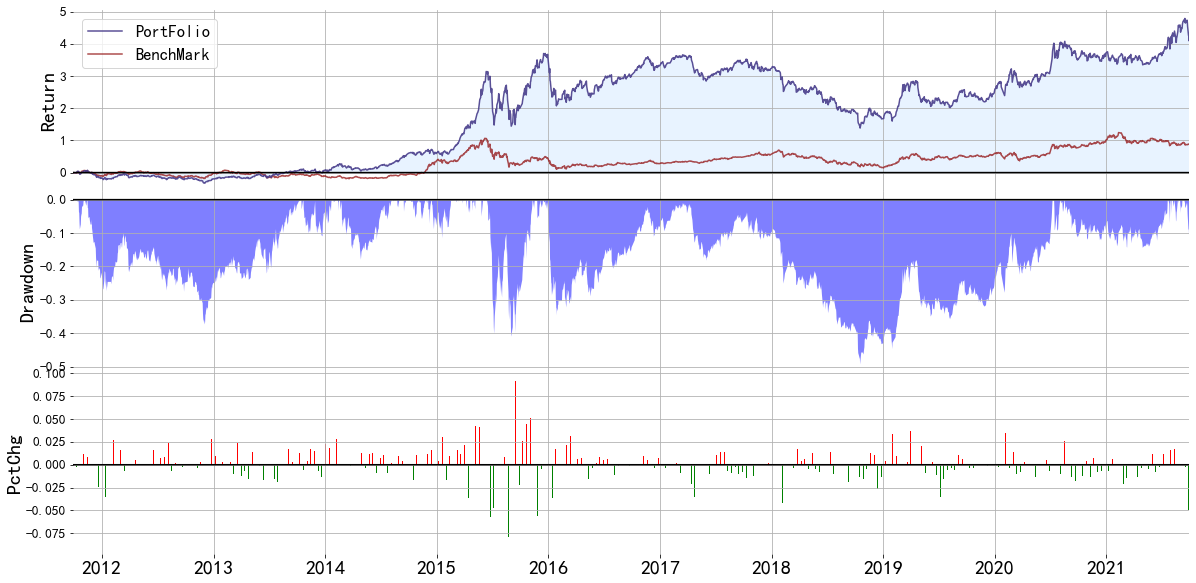

In [177]:
mdf,rdf = metric_fun(caplist,daterange,rf,benchmark)
fig = plot(rdf,20)
mdf

# 60日滚动收益率和夏普率

In [ ]:
####相对于60天前股票价格的收益率

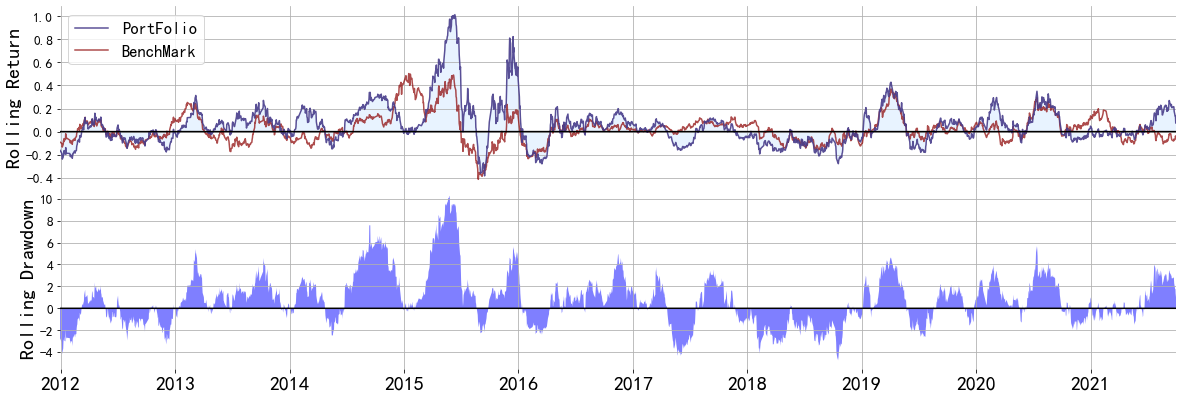

In [179]:
rolling_plot(rdf,rf,60,20)

In [ ]:
##result：
##存在一些时间跑不赢沪深300
##60日滚动夏普率大部分时间是正的

# 牛市时间段回测

,,,,
,回测收益,118.368%,年化收益,188.484%
,年化夏普,4.51357,年化索提诺,6.42508
,最大回撤,11.506%,卡尔玛率,16.38150
,最大回撤开始时间,20141215,最大回撤结束时间,20150119
,策略波动率,0.01786,日胜率,0.64331
,盈利天数,101,亏损天数,56
,基准收益,112.392%,超额收益,5.976%
,基准波动率,0.01730,超额最大回撤,0.130%
,日均超额收益,0.020%,信息比率(年化),0.21903
,alpha,0.00208,beta,0.62231


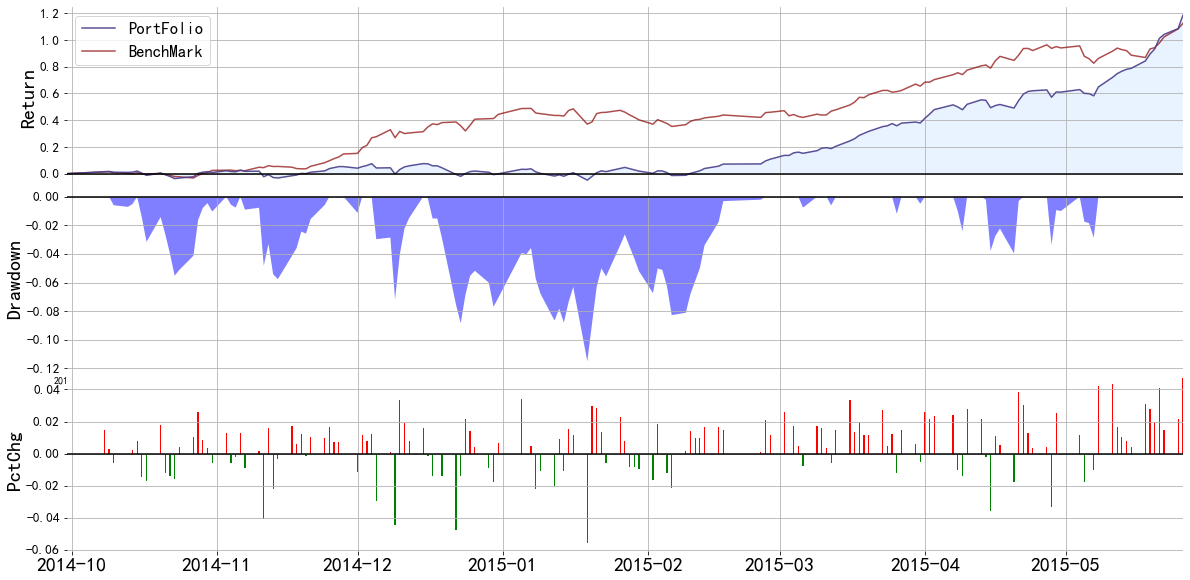

In [102]:
day1 = '20140930'  #开始时间
day2 = '20150527'  #结束时间

n0 = daterange.index(day1)
n1 = daterange.index(day2)

tempdate = daterange[n0:n1]
tempcap = caplist[n0:n1]
tempbm = benchmark.iloc[n0:n1,:]
mdf,rdf = metric_fun(tempcap,tempdate,rf,tempbm)
fig = plot(rdf,20)
mdf

In [ ]:
##result：
##回测收益和基准收益相差不大（118.368%-112.392%）
##在牛市初期，落后于沪深300

# 熊市时间段回测

,,,,
,回测收益,1.185%,年化收益,1.210%
,年化夏普,0.26268,年化索提诺,0.34362
,最大回撤,41.037%,卡尔玛率,0.02948
,最大回撤开始时间,20150612,最大回撤结束时间,20150902
,策略波动率,0.03471,日胜率,0.56327
,盈利天数,138,亏损天数,107
,基准收益,-40.861%,超额收益,42.047%
,基准波动率,0.02491,超额最大回撤,6.705%
,日均超额收益,0.221%,信息比率(年化),1.61192
,alpha,0.00234,beta,1.08718


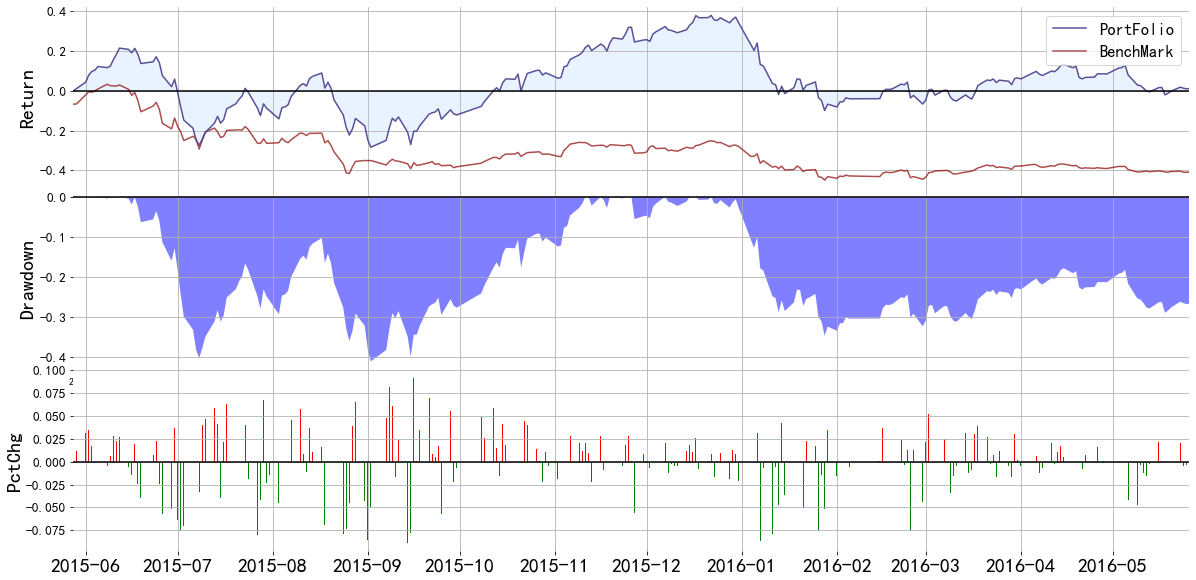

In [104]:
day1 = '20150528'  #开始时间
day2 = '20160527'  #结束时间

n0 = daterange.index(day1)
n1 = daterange.index(day2)

tempdate = daterange[n0:n1]
tempcap = caplist[n0:n1]
tempbm = benchmark.iloc[n0:n1,:]
mdf,rdf = metric_fun(tempcap,tempdate,rf,tempbm)
fig = plot(rdf,20)
mdf

In [ ]:
##result：
##基准在熊市期间下跌了40%，而策略没跌，上涨了1%

# 近三年回测表现

,,,,
,回测收益,73.754%,年化收益,25.293%
,年化夏普,0.76786,年化索提诺,1.01043
,最大回撤,21.670%,卡尔玛率,1.16721
,最大回撤开始时间,20190419,最大回撤结束时间,20190809
,策略波动率,0.01699,日胜率,0.53909
,盈利天数,393,亏损天数,336
,基准收益,42.025%,超额收益,31.729%
,基准波动率,0.01358,超额最大回撤,1.036%
,日均超额收益,0.034%,信息比率(年化),0.46380
,alpha,0.00040,beta,0.90466


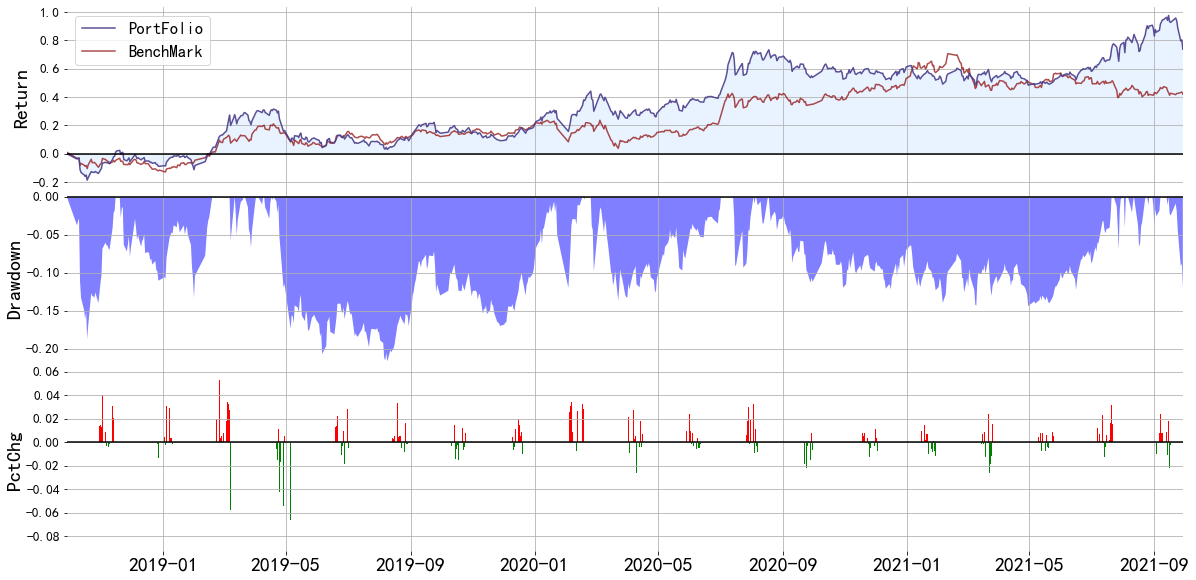

In [109]:
day1 = '20180928'  #开始时间
day2 = '20210930'  #结束时间

n0 = daterange.index(day1)
n1 = daterange.index(day2)

tempdate = daterange[n0:n1]
tempcap = caplist[n0:n1]
tempbm = benchmark.iloc[n0:n1,:]
mdf,rdf = metric_fun(tempcap,tempdate,rf,tempbm)
fig = plot(rdf,20)
mdf

# 交易日志

In [ ]:
###第一个的交易日志

In [189]:
log_df

,date,order,security,amount,price
0,20110930,买入,600503.SH,99900.0,9.00
1,20110930,买入,000609.SZ,99216.0,8.48
2,20110930,买入,600733.SH,99636.0,17.48
3,20110930,买入,000005.SZ,99974.0,3.86
4,20110930,买入,000838.SZ,99648.0,10.38
...,...,...,...,...,...
24095,20210930,买入,600881.SH,525104.0,2.96
24096,20210930,买入,600376.SH,525132.0,5.22
24097,20210930,买入,688569.SH,523625.0,17.75
24098,20210930,买入,002244.SZ,524920.0,4.40


# 回测期期末持仓

In [ ]:
###一直持仓到2021年10月31日

In [197]:
##在2021年9月30日开始的持仓
last = pd.DataFrame(np.array(codelist[-1]).reshape(-1,5))
last.columns = ['']*last.shape[1]
last.index = ['']*last.shape[0]
last

,,,,,
,000608.SZ,600545.SH,603021.SH,600716.SH,000736.SZ
,600675.SH,600603.SH,000006.SZ,002564.SZ,600512.SH
,605319.SH,000987.SZ,600638.SH,600648.SH,000029.SZ
,000042.SZ,000048.SZ,600629.SH,600657.SH,000517.SZ
,002781.SZ,600823.SH,300237.SZ,600383.SH,300309.SZ
,600528.SH,603111.SH,600498.SH,600070.SH,600606.SH
,002828.SZ,000070.SZ,002016.SZ,600663.SH,002789.SZ
,603680.SH,603018.SH,002225.SZ,600996.SH,000868.SZ
,002339.SZ,002426.SZ,002856.SZ,300407.SZ,300190.SZ
,600501.SH,603829.SH,600232.SH,000838.SZ,600718.SH
